In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd

import bz2
import _pickle

from const import hka_red, iwi_purple

In [2]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 18})
original_matlab_data_path = 'data/SVD-Meaningful_PCs/allFaces.mat'
pickle_data_path = 'data/SVD-Meaningful_PCs/faces.pkl.pbz2'

In [3]:
# source: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
# Compress and decompress faces data to pickle file

def compress_data(title, data):
    with bz2.BZ2File(title, 'w') as f:
        _pickle.dump(data, f)


def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = _pickle.load(data)
    return data.to_numpy()

In [4]:
def load_original_matlab_values():
    _mat_contents = scipy.io.loadmat(original_matlab_data_path)
    _faces = _mat_contents['faces']
    _m = int(_mat_contents['m'])
    _n = int(_mat_contents['n'])
    # flatten to one dimension
    _n_faces = np.ndarray.flatten(_mat_contents['nfaces'])
    _training_faces = _faces[:, :np.sum(_n_faces[:36])]
    return _mat_contents, _training_faces, _m, _n, _n_faces


def compress_original_data(_training_faces):
    np_contents = _training_faces.astype(np.uint8)
    df_contents = pd.DataFrame(np_contents)
    compress_data(pickle_data_path, df_contents)

# mat_contents, training_faces, m, n, n_faces = load_original_matlab_values()
# compress_original_data(training_faces)

In [5]:
training_faces = decompress_pickle(pickle_data_path)
m = 168
n = 192
# person 1 has 64 pictures, person 2 has 62 pictures etc.
n_faces = [64, 62, 64, 64, 62, 64, 64, 64, 64, 64, 60, 59, 60, 63, 62, 63, 63,
           64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
           64, 64]

In [6]:
total_faces_checksum = 0
for face_number in n_faces:
    total_faces_checksum += face_number
print(f"Total faces: {total_faces_checksum}")
print(f"Resolution: {m * n}")
print(f"Faces data set shape: {training_faces.shape}")

Total faces: 2282
Resolution: 32256
Faces data set shape: (32256, 2282)


In [7]:
avg_face = np.mean(training_faces, axis=1)
total_amount_of_pictures = training_faces.shape[1]

# Compute eigen-faces on mean-subtracted training data
X_raw = training_faces
X_mean_subtracted = training_faces - np.tile(avg_face, (total_amount_of_pictures, 1)).T

u_raw, sigma_raw, vT_raw = np.linalg.svd(X_raw, full_matrices=False)
u_mean_subtracted, sigma_mean_subtracted, vT_mean_subtracted = np.linalg.svd(X_mean_subtracted, full_matrices=False)

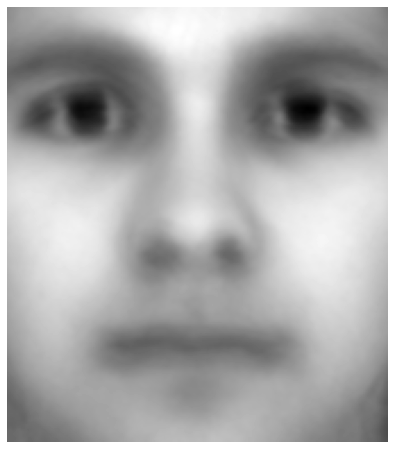

In [8]:
fig1 = plt.figure()

# Average face:

ax1 = fig1.add_subplot(111)
np_avg_face = np.reshape(avg_face, (m, n)).T
img_avg = ax1.imshow(np_avg_face)
img_avg.set_cmap('gray')
plt.axis('off')

plt.show()

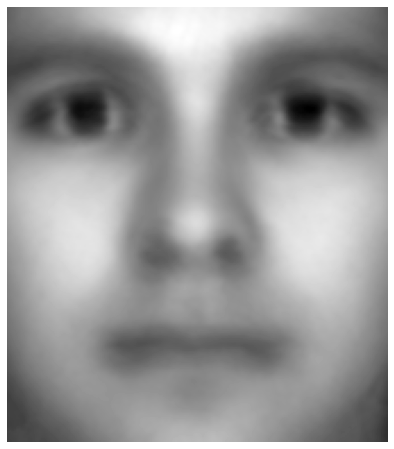

In [9]:
fig2 = plt.figure()

# (Inverted) correlated face (Raw data):

ax2 = fig2.add_subplot(111)
np_faces_correlation_raw = np.reshape(u_raw[:, 0], (m, n)).T
img_u1 = ax2.imshow(np_faces_correlation_raw)
img_u1.set_cmap('gray_r')
plt.axis('off')

plt.show()

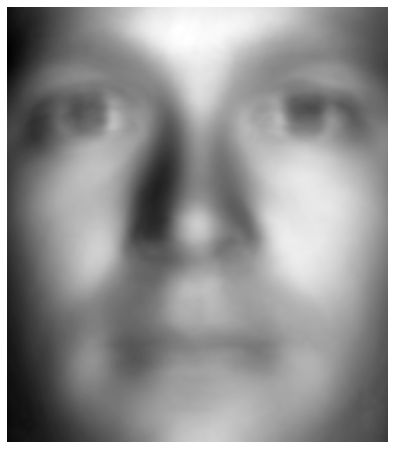

In [10]:
fig3 = plt.figure()

# (Inverted) correlated face (Mean subtracted data):

ax3 = fig3.add_subplot(111)
np_faces_correlation_mean_subtracted = np.reshape(u_mean_subtracted[:, 0], (m, n)).T
img_u2 = ax3.imshow(np_faces_correlation_mean_subtracted)
img_u2.set_cmap('gray_r')
plt.axis('off')

plt.show()

In [11]:
# Person 3 & 12 show a nice discrepancy between mean and raw data
p1_num = 2  # Person number 2
p2_num = 7  # Person number 7

pc1 = 5
pc2 = 6
PCA_modes = [pc1, pc2]  # Project onto PCA modes 5 and 6

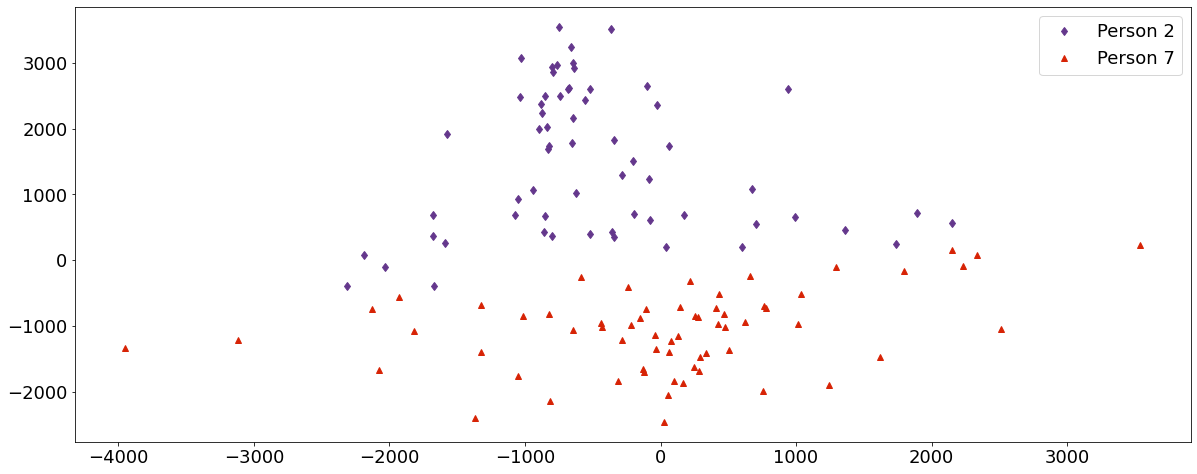

In [12]:
columns_faces_p1_left_delimiter = np.sum(n_faces[:(p1_num - 1)])
columns_faces_p1_right_delimiter = np.sum(n_faces[:p1_num])
columns_faces_p2_left_delimiter = np.sum(n_faces[:(p2_num - 1)])
columns_faces_p2_right_delimiter = np.sum(n_faces[:p2_num])

# on mean subtracted data

p1 = training_faces[:, columns_faces_p1_left_delimiter:columns_faces_p1_right_delimiter]
p2 = training_faces[:, columns_faces_p2_left_delimiter:columns_faces_p2_right_delimiter]

p1 = p1 - np.tile(avg_face, (p1.shape[1], 1)).T
p2 = p2 - np.tile(avg_face, (p2.shape[1], 1)).T

PCA_coordinates_P1 = u_mean_subtracted[:, PCA_modes - np.ones_like(PCA_modes)].T @ p1
PCA_coordinates_P2 = u_mean_subtracted[:, PCA_modes - np.ones_like(PCA_modes)].T @ p2

plt.plot(
    PCA_coordinates_P1[0, :],
    PCA_coordinates_P1[1, :],
    'd',
    color=iwi_purple,
    label=f'Person {p1_num}'
)
plt.plot(
    PCA_coordinates_P2[0, :],
    PCA_coordinates_P2[1, :],
    '^',
    color=hka_red,
    label=f'Person {p2_num}'
)

plt.legend()
plt.show()

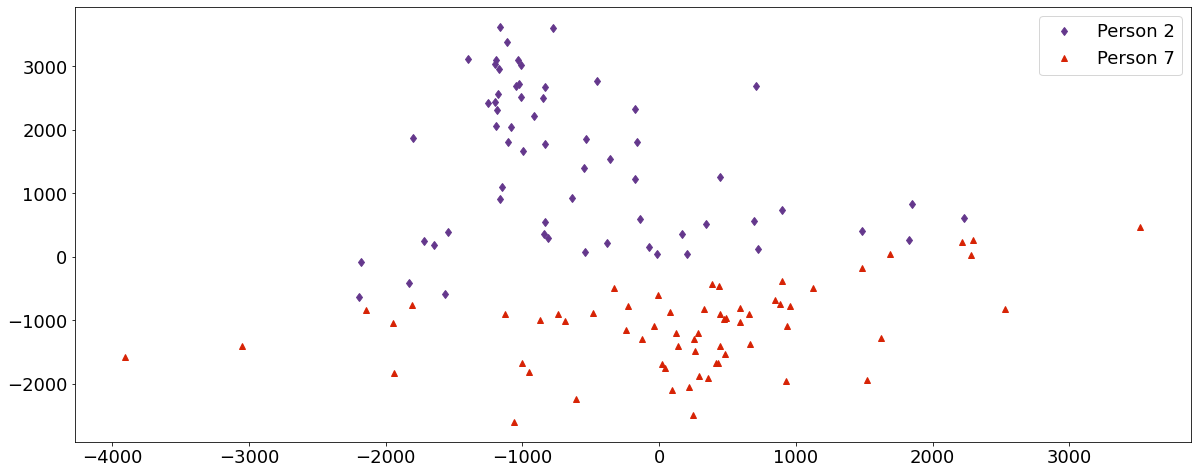

In [13]:
p1 = training_faces[:, columns_faces_p1_left_delimiter:columns_faces_p1_right_delimiter]
p2 = training_faces[:, columns_faces_p2_left_delimiter:columns_faces_p2_right_delimiter]

# data not centered


PCA_coordinates_P1 = u_raw[:, PCA_modes - np.ones_like(PCA_modes)].T @ p1
PCA_coordinates_P2 = u_raw[:, PCA_modes - np.ones_like(PCA_modes)].T @ p2

plt.plot(
    PCA_coordinates_P1[0, :],
    PCA_coordinates_P1[1, :],
    'd',
    color=iwi_purple,
    label=f'Person {p1_num}'
)
plt.plot(
    PCA_coordinates_P2[0, :],
    PCA_coordinates_P2[1, :],
    '^',
    color=hka_red,
    label=f'Person {p2_num}'
)

plt.legend()
plt.show()